#Imports

In [7]:
#Standard data processing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#To unpickle the dataset
import pickle

#For gabage collection
import gc

#To visualize images and graphs
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

#Using keras Sequential API to build a model
import keras
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.layers import Layer
from keras.models import Model,Sequential
from keras.layers import Input,Flatten,Dense
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras.models import load_model

Using TensorFlow backend.


#Colab File Handling

##Mounting Google Drive and processing files (with workflow)

In [13]:
#Mounting google drive for file i/o
from google.colab import drive
while(True):
    
    # A try-catch loop fixes the issue of the mount timing out
    try:
        drive.mount('/content/gdrive')
        break;
    except:
        continue

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
#Switching to the task directory
cd gdrive/My\ Drive/IIIT-D\ Task/

[Errno 2] No such file or directory: 'gdrive/My Drive/IIIT-D Task/'
/content/gdrive/My Drive/IIIT-D Task


In [0]:
PATH = "Vision_task_dataset_public/"

In [16]:
!ls Vision_task_dataset_public/

'hitkul(sample_submission).csv'   train_image.pkl
 test_image.pkl			  train_label.pkl


In [0]:
#Unpickling and loading the files
with open(PATH + 'train_image.pkl', 'rb') as f:
    train_data = pickle.load(f)
    
with open(PATH + 'test_image.pkl', 'rb') as f:
    test_data = pickle.load(f)
    
with open(PATH + 'train_label.pkl', 'rb') as f:
    train_label = pickle.load(f)
    
sample_submission = pd.read_csv(PATH + "hitkul(sample_submission).csv")

In [18]:
#Figuring out the type and size of data
print(type(train_data))
print(type(train_data[0]))
print(type(train_label))
print(train_data.__len__())
print(train_data[0].__len__())

<class 'list'>
<class 'list'>
<class 'list'>
8000
784


The images have shape 784, suggestiing they are 28*28 images

In [19]:
#Convert list to numpy array so that it can be passed to model
train_data = np.array(train_data)
test_data = np.array(test_data)
train_label = np.array(train_label)
#Reshaping to 28*28 with 1 channel for cnn operations
train_data = train_data.reshape([-1,28,28,1])
test_data = test_data.reshape([-1,28,28,1])
#Conversion to float32 is memory efficent and hardly affects accuracy
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
print(train_data.shape)
print(test_data.shape)

(8000, 28, 28, 1)
(2000, 28, 28, 1)


In [20]:
#Figuring out label value to encode to one hot
np.unique(train_label)

array([0, 2, 3, 6])

In [0]:
#onverting to one hot encodable
train_label[train_label == 2] = 1
train_label[train_label == 3] = 2
train_label[train_label == 6] = 3

In [22]:
np.unique(train_label)

array([0, 1, 2, 3])

In [0]:
#encoding, finally!
number_of_classes = 4

train_label = np_utils.to_categorical(train_label, number_of_classes)

In [24]:
train_label.shape

(8000, 4)

In [0]:
training_data,validation_data,training_label,validation_label = train_test_split(train_data,train_label, test_size=0.20, random_state=42)

In [26]:
validation_label[0:5,:]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

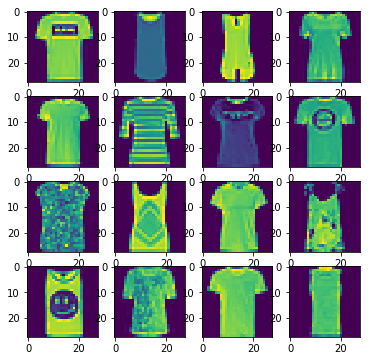

In [40]:
f, ax = plt.subplots(4,4, figsize=(6, 6))
for index in range(16):
    ax[int(index/4),index%4].imshow(train_data[index,:,:,0])
f.show()

In [28]:
train_data.shape

(8000, 28, 28, 1)

##Training setup

In [0]:
#Fixing vales that'll be used commonly
NUM_TRAIN = train_data.shape[0]
TRAIN_SIZE = training_data.shape[0]
VALIDATE_SIZE = validation_data.shape[0]
IMAGE_SHAPE = train_data.shape[1:4]
BATCH_SIZE = 12
EPOCHS = 10

In [0]:
#Setting up the generators, with data augmentation for training to help as dataset is small
train_datagen = ImageDataGenerator(
    #rotation_range=15,
    rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow(training_data,training_label,batch_size = BATCH_SIZE)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow(validation_data, validation_label)

#Attempt 1 

##An attempt using a shallow net first to classify (This is used for prediction finally)

In [0]:
Classifier = Sequential()
Classifier.add(Conv2D(filters = 16, kernel_size = (3,3), input_shape = IMAGE_SHAPE, activation = 'relu'))
Classifier.add(BatchNormalization(axis=-1))
Classifier.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
Classifier.add(BatchNormalization(axis=-1))
Classifier.add(MaxPooling2D((2,2), strides = 2))
Classifier.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
Classifier.add(MaxPooling2D((2,2), strides = 2))
Classifier.add(Flatten())
Classifier.add(Dense(256, activation = 'relu'))
Classifier.add(Dropout(0.2))
Classifier.add(Dense(4, activation = 'softmax'))
Classifier.summary()

In [0]:
Classifier.compile(loss='categorical_crossentropy',optimizer=optimizers.adam(lr=1e-4),metrics=['acc'])

In [31]:
Classifier = load_model("shallow_model.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
#Callbacks to help training
earlystop = EarlyStopping(patience=70)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
mc = ModelCheckpoint(
        "shallow_model.h5",
        monitor='val_acc',
        save_best_only=True,
        mode='max',
        verbose=1)
callbacks = [earlystop, learning_rate_reduction,mc]

In [0]:
BATCH_SIZE = 256

In [34]:
epochs=1000
history = Classifier.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=VALIDATE_SIZE//BATCH_SIZE,
    steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
    callbacks=callbacks
)
Classifier.save("s_model.g5")

Epoch 1/1000
25/25 [==============================] - 2s 69ms/step - loss: 0.3097 - acc: 0.8800 - val_loss: 0.3294 - val_acc: 0.8542

Epoch 00001: val_acc improved from -inf to 0.85417, saving model to shallow_model.h5
Epoch 2/1000
25/25 [==============================] - 1s 54ms/step - loss: 0.3453 - acc: 0.8967 - val_loss: 0.5303 - val_acc: 0.8021

Epoch 00002: val_acc did not improve from 0.85417
Epoch 3/1000
25/25 [==============================] - 1s 54ms/step - loss: 0.3059 - acc: 0.8633 - val_loss: 0.3541 - val_acc: 0.8750

Epoch 00003: val_acc improved from 0.85417 to 0.87500, saving model to shallow_model.h5
Epoch 4/1000
25/25 [==============================] - 1s 54ms/step - loss: 0.3087 - acc: 0.8867 - val_loss: 0.3802 - val_acc: 0.8490

Epoch 00004: val_acc did not improve from 0.87500
Epoch 5/1000
25/25 [==============================] - 1s 53ms/step - loss: 0.3603 - acc: 0.8367 - val_loss: 0.3779 - val_acc: 0.8385

Epoch 00005: val_acc did not improve from 0.87500
Epoch 6

In [0]:
Classifier = load_model("shallow_model.h5")

In [0]:
prediction = Classifier.predict(test_data)
prediction = np.argmax(prediction, axis = 1)
prediction[prediction == 1] = 2
prediction[prediction == 2] = 3
prediction[prediction == 3] = 6

In [37]:
df = pd.DataFrame({'image_index': list(np.arange(len(prediction))) ,'class': prediction})
df = df[['image_index', 'class']]
df.head()

,image_index,class
0,0,6
1,1,6
2,2,6
3,3,0
4,4,0


In [0]:
df.to_csv('test_submission.csv', index=False)

In [0]:
from google.colab import files
files.download('test_submission.csv') 

#Attempt 2

###Model definition

In [0]:
#Building the VGG model for 1D data
def VGG1D():
    input_tensor=Input(shape=(IMAGE_SHAPE))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax', name='predictions')(x)
    return Model(inputs=[input_tensor],outputs=[x])

In [0]:
Classifier = VGG1D()

In [0]:
Classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0         
__________

In [0]:
Classifier.compile(loss='categorical_crossentropy',optimizer=optimizers.sgd(),metrics=['acc'])

In [0]:
!ls

classifier_model.h5  s_model.g5		   transfer_model.h5
deep_model.h5	     test_submission2.csv  Vision_task_dataset_public
model.g5	     test_submission.csv
shallow_model.h5     t_model.g5


###Model Training

In [0]:
Classifier = load_model("deep_model.h5")

In [0]:
earlystop = EarlyStopping(patience=25)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
mc = ModelCheckpoint(
        "deep_model.h5",
        monitor='val_acc',
        save_best_only=True,
        mode='max',
        verbose=1)
callbacks = [earlystop, learning_rate_reduction,mc]

In [0]:
BATCH_SIZE = 64

In [0]:
epochs=5
history = Classifier.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=VALIDATE_SIZE//BATCH_SIZE,
    steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
    callbacks=callbacks
)
#Classifier.save("d_model.g5")

Epoch 1/5
100/100 [==============================] - 91s 912ms/step - loss: 0.6089 - acc: 0.7417 - val_loss: 0.5650 - val_acc: 0.7475

Epoch 00001: val_acc did not improve from 0.77750
Epoch 2/5
100/100 [==============================] - 91s 908ms/step - loss: 0.6405 - acc: 0.7283 - val_loss: 0.6091 - val_acc: 0.7550

Epoch 00002: val_acc did not improve from 0.77750
Epoch 3/5
100/100 [==============================] - 92s 921ms/step - loss: 0.6131 - acc: 0.7350 - val_loss: 0.6537 - val_acc: 0.7188

Epoch 00003: val_acc did not improve from 0.77750
Epoch 4/5
100/100 [==============================] - 91s 908ms/step - loss: 0.5877 - acc: 0.7675 - val_loss: 0.5015 - val_acc: 0.7812

Epoch 00004: val_acc improved from 0.77750 to 0.78125, saving model to deep_model.h5
Epoch 5/5
100/100 [==============================] - 92s 923ms/step - loss: 0.6209 - acc: 0.7458 - val_loss: 0.5922 - val_acc: 0.7475

Epoch 00005: val_acc did not improve from 0.78125


In [0]:
prediction = Classifier.predict(test_data)
prediction = np.argmax(prediction, axis = 1)
prediction[prediction == 1] = 2
prediction[prediction == 2] = 3
prediction[prediction == 3] = 6

In [0]:
prediction.shape

(2000,)

In [0]:
df = pd.DataFrame({'image_index': list(np.arange(len(prediction))) ,'class': prediction})
df = df[['image_index', 'class']]
df.head()

,class,image_index
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [0]:
sample_submission

,image_index,class
0,0,2
1,1,3
2,2,0
3,3,6


In [0]:
df.to_csv('test_submission.csv', index=False)